<a href="https://colab.research.google.com/github/geragland/BME450-CartilageMRI/blob/main/BME450_CartilageMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Column names:
('examId', 'seriesNo', 'aclDiagnosis', 'kneeLR', 'roiX', 'roiY', 'roiZ', 'roiHeight', 'roiWidth', 'roiDepth', 'volumeFilename')

Shape of volume "/content/drive/MyDrive/Datasets/MRIData/train/390116-9.pck": (25, 320, 320)


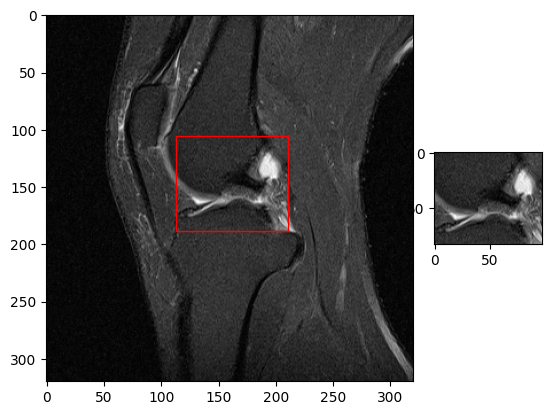

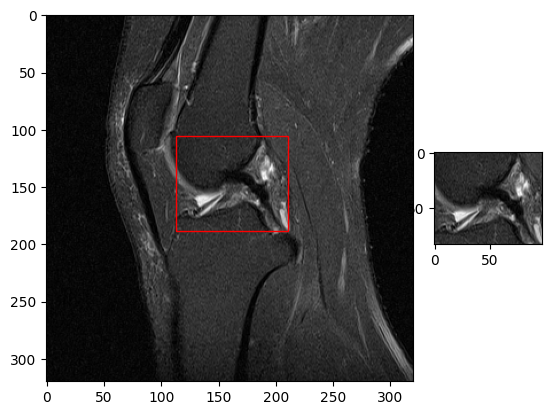

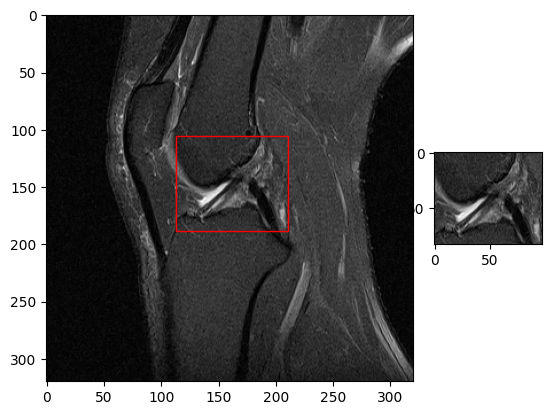

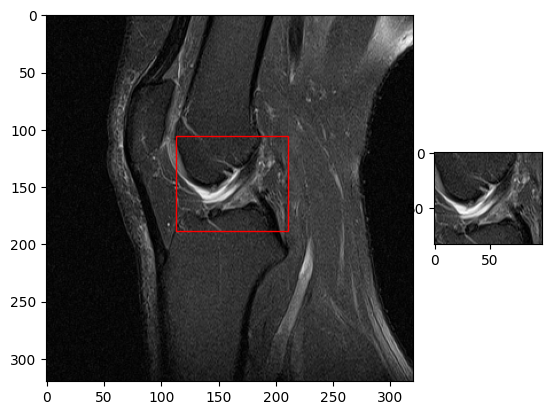

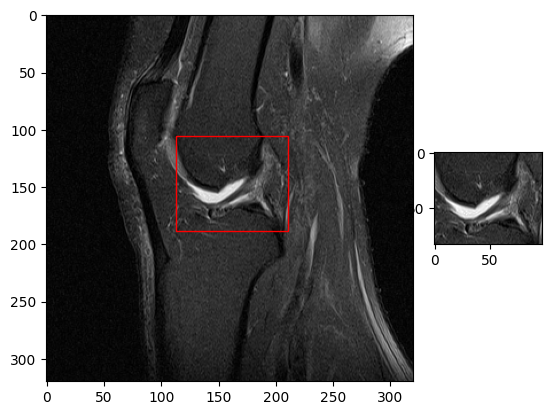

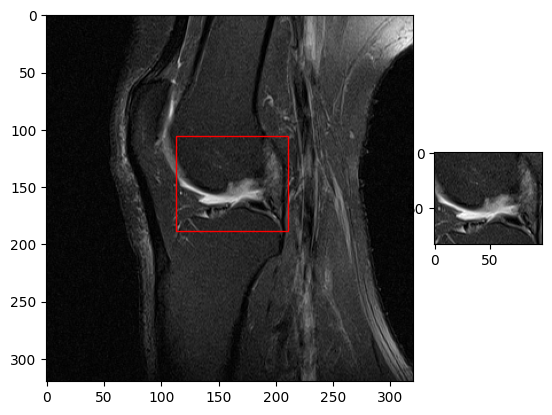

In [ ]:
#from this link: http://www.riteh.uniri.hr/~istajduh/projects/kneeMRI/

import pickle
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch

import numpy
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

# directory where the volumetric data is located
volumetric_data_dir = '/content/drive/MyDrive/Datasets/MRIData/train'
volumetric_data_dir_test = '/content/drive/MyDrive/Datasets/MRIData/test'

# path to metadata csv file
metadata_train_csv_path = '/content/drive/MyDrive/Datasets/MRIData/metadata_train.csv'
metadata_test_csv_path = '/content/drive/MyDrive/Datasets/MRIData/metadata_test.csv'


# names=True loads the interprets the first row of csv file as column names
# 'i4' = 4 byte signed integer, 'U20' = unicode max 20 char string
metadata_train = np.genfromtxt(metadata_train_csv_path, delimiter=',', names=True,
    dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')
metadata_test = np.genfromtxt(metadata_test_csv_path, delimiter=',', names=True,
    dtype='i4,i4,i4,i4,i4,i4,i4,i4,i4,i4,U20')

print('Column names:')
print(metadata_train.dtype.names)

# Select all rows where examID == 329637
exams = metadata_train[metadata_train['examId'] == 390116]

for exam in exams:
    vol_data_file = exam['volumeFilename']

    vol_data_path = os.path.join(volumetric_data_dir, vol_data_file)

    # Load data from file
    with open(vol_data_path, 'rb') as file_handler: # Must use 'rb' as the data is binary
        volumetric_data = pickle.load(file_handler)

    print('\nShape of volume "%s":' % vol_data_path, volumetric_data.shape)

    # Get all roi slices from volume
    z_start = exam['roiZ']
    depth = exam['roiDepth']

    for z in range(z_start, z_start + depth):

        slice = volumetric_data[z, :, :]

        # Get roi dimensions
        x, y, w, h = [exam[attr] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]

        # Extract ROI
        roi = slice[y:y+h, x:x+w]

        # Plot slice and roi
        figure = plt.figure()
        plot = plt.subplot2grid((1, 4), (0, 0), 1, 3) # This makes the slice plot larger than roi plot
        plot.add_patch(patch.Rectangle((x, y), w, h, fill=None, color='red'))
        plot.imshow(slice, cmap='gray')
        plot = plt.subplot2grid((1, 4), (0, 3), 1, 1)
        plot.imshow(roi, cmap='gray')

        plt.show()

In [ ]:
categories = ['healthy', 'partial', 'rupture']

healthyID = []
partialID = []
ruptureID = []

examID = metadata_train['examId']
aclDiagnosis = metadata_train['aclDiagnosis']

for i in range(0, examID.size):
  if aclDiagnosis[i] == 0:
    healthyID.append(examID[i])
  elif aclDiagnosis[i] == 1:
    partialID.append(examID[i])
  elif aclDiagnosis[i] == 2:
    ruptureID.append(examID[i])

categories = ['healthy', 'partial', 'rupture']

healthyID_test = []
partialID_test = []
ruptureID_test = []

examID = metadata_test['examId']
aclDiagnosis = metadata_test['aclDiagnosis']

for i in range(0, examID.size):
  if aclDiagnosis[i] == 0:
    healthyID_test.append(examID[i])
  elif aclDiagnosis[i] == 1:
    partialID_test.append(examID[i])
  elif aclDiagnosis[i] == 2:
    ruptureID_test.append(examID[i])

In [ ]:
healthy = []
partial = []
rupture = []

for a in [healthyID, partialID, ruptureID]:
  for b in range(0, len(a)):
    exams = metadata_train[metadata_train['examId'] == a[b]]

    for exam in exams:
      vol_data_file = exam['volumeFilename']

      vol_data_path = os.path.join(volumetric_data_dir, vol_data_file)

      # Load data from file
      with open(vol_data_path, 'rb') as file_handler: # Must use 'rb' as the data is binary
          volumetric_data = pickle.load(file_handler)

      #print('\nShape of volume "%s":' % vol_data_path, volumetric_data.shape)

  # Get all roi slices from volume
      z_start = exam['roiZ']
      depth = exam['roiDepth']

      #for z in range(z_start, z_start + depth):
      # for now, just using the first slice that is identified by z_start

      count = 0

      # Get roi dimensions
      x, y, w, h = [exam[attr] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]

      # Extract ROI
      if a == healthyID:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          healthy.append([roi, 0])
          z_start = z_start + 1
          count = count + 1
      elif a == partialID:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          partial.append([roi, 1])
          z_start = z_start + 1
          count = count + 1
      elif a == ruptureID:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          rupture.append([roi, 2])
          z_start = z_start + 1
          count = count + 1

healthy_test = []
partial_test = []
rupture_test = []

for a in [healthyID_test, partialID_test, ruptureID_test]:
  for b in range(0, len(a)):
    exams = metadata_test[metadata_test['examId'] == a[b]]

    for exam in exams:
      vol_data_file = exam['volumeFilename']

      vol_data_path = os.path.join(volumetric_data_dir_test, vol_data_file)

      # Load data from file
      with open(vol_data_path, 'rb') as file_handler: # Must use 'rb' as the data is binary
          volumetric_data = pickle.load(file_handler)

      #print('\nShape of volume "%s":' % vol_data_path, volumetric_data.shape)

  # Get all roi slices from volume
      z_start = exam['roiZ']
      depth = exam['roiDepth']

      #for z in range(z_start, z_start + depth):
      # for now, just using the first slice that is identified by z_start

      count = 0

      # Get roi dimensions
      x, y, w, h = [exam[attr] for attr in ['roiX', 'roiY', 'roiWidth', 'roiHeight']]

      # Extract ROI
      if a == healthyID_test:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          healthy_test.append([roi, 0])
          z_start = z_start + 1
          count = count + 1
      elif a == partialID_test:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          partial_test.append([roi, 1])
          z_start = z_start + 1
          count = count + 1
      elif a == ruptureID_test:
        while count < depth:
          slice = volumetric_data[z_start, :, :]
          roi = slice[y:y+h, x:x+w]
          rupture_test.append([roi, 2])
          z_start = z_start + 1
          count = count + 1

Number of samples in training array: 1422
Number of samples in training array: 344
Number of samples in training array: 114
Number of samples in testing array: 952
Number of samples in testing array: 242
Number of samples in testing array: 72
Inputs sample - min,max,mean,std: 1.2140209674835205 1495.8306884765625 415.59539794921875 171.74510192871094
Inputs sample normalized - min,max,mean,std: -2.4127697944641113 6.289759159088135 1.0133920369526095e-07 1.0


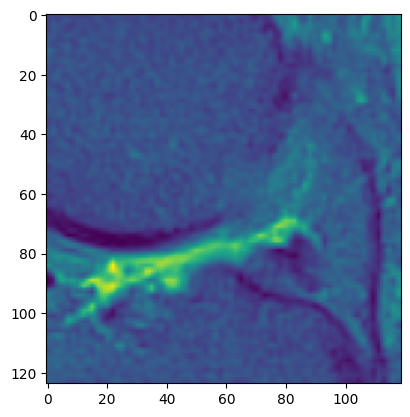

In [ ]:
# let us print some data:
categories = ['healthy', 'partial', 'rupture']

training_data = []

min_x = healthy[0][0].shape[0]
min_y = healthy[0][0].shape[1]

# select a random sample from the training set
for a in [healthy, partial, rupture]:
  for b in range(0, len(a)):
    sample_num = b
  #print(training_data[sample_num])
    if b == len(a)-1:
      print('Number of samples in training array:', len(a))

    if(a[sample_num][0].shape[0] > min_x):
      min_x = a[sample_num][0].shape[0]
    if(a[sample_num][0].shape[1] > min_y):
      min_y = a[sample_num][0].shape[1]

    a[sample_num][0] = torch.tensor(a[sample_num][0].astype('float32'))
    a[sample_num][0] = a[sample_num][0].unsqueeze(0)
    training_data.append(a[sample_num])
    #print(a[sample_num][0].shape)

#print("Minimum x size = ", min_x)
#print("Minimum y size = ", min_y)

transform = transforms.Compose(
  [transforms.Normalize(0.5,0.5),
   transforms.Resize((min_x,min_y))])

for b in range(0, len(training_data)):
  sample_num = b
  training_data[sample_num][0] = transform(training_data[sample_num][0])
  #print(a[sample_num][0].shape)

# let us print some data:
categories = ['healthy', 'partial', 'rupture']

test_data = []

# select a random sample from the training set
for a in [healthy_test, partial_test, rupture_test]:
  for b in range(0, len(a)):
    sample_num = b
  #print(training_data[sample_num])
    if b == len(a)-1:
      print('Number of samples in testing array:', len(a))

    a[sample_num][0] = torch.tensor(a[sample_num][0].astype('float32'))
    a[sample_num][0] = a[sample_num][0].unsqueeze(0)
    test_data.append(a[sample_num])
    #print(a[sample_num][0].shape)

#print("Minimum x size = ", min_x)
#print("Minimum y size = ", min_y)

for b in range(0, len(test_data)):
  sample_num = b
  test_data[sample_num][0] = transform(test_data[sample_num][0])
  #print(a[sample_num][0].shape)

ima = training_data[0][0]
print('Inputs sample - min,max,mean,std:', ima.min().item(), ima.max().item(), ima.mean().item(), ima.std().item())
ima = (ima - ima.mean())/ ima.std()
print('Inputs sample normalized - min,max,mean,std:', ima.min().item(), ima.max().item(), ima.mean().item(), ima.std().item())
iman = ima.permute(1, 2, 0) # needed to be able to plot
plt.imshow(iman)

In [ ]:
print(len(training_data))
print(len(test_data))

1880
1266


In [ ]:
#base model

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(min_x*min_y, 512)
        self.l2 = nn.Linear(512, 512)
        self.l3 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        output = self.l3(x)
        return output

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, test_accuracy, test, i):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    test_accuracy[i] = 100*correct
    test[i] = test_loss

In [ ]:
# training!
#for learning_rate in [1e-1,1e-2,1e-3,1e-4,1e-5]
model = Net()

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

learning_rate = 1e-3
batch_size = 64

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
i = 0
test_accuracy = np.zeros(epochs)
test_loss = np.zeros(epochs)
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, loss_fn, optimizer)
  test_loop(test_dataloader, model, loss_fn, test_accuracy, test_loss, i)
  i = i + 1
print("Done!")

Epoch 1
-------------------------------
loss: 151.947632  [   64/ 1880]
Test Error: 
 Accuracy: 5.7%, Avg loss: 158902723379.200012 

Epoch 2
-------------------------------
loss: 122200981504.000000  [   64/ 1880]
Test Error: 
 Accuracy: 5.7%, Avg loss: 2174927798272.000000 

Epoch 3
-------------------------------
loss: 269318848512.000000  [   64/ 1880]
Test Error: 
 Accuracy: 5.7%, Avg loss: 15830083226686640877469696.000000 

Epoch 4
-------------------------------
loss: 12349981018119588729061376.000000  [   64/ 1880]
Test Error: 
 Accuracy: 19.2%, Avg loss: 163622100.046875 

Epoch 5
-------------------------------
loss: 39132.882812  [   64/ 1880]
Test Error: 
 Accuracy: 19.2%, Avg loss: 163592041.027610 

Epoch 6
-------------------------------
loss: 2.299762  [   64/ 1880]
Test Error: 
 Accuracy: 19.2%, Avg loss: 163592041.013213 

Epoch 7
-------------------------------
loss: 2.280451  [   64/ 1880]
Test Error: 
 Accuracy: 75.2%, Avg loss: 163592040.998893 

Epoch 8
--------

In [ ]:
correct_ID = 0
healthy_number = 0
other = 0

for a in range(0, len(test_data)):
  sample_num = a # select a random sample

  with torch.no_grad():
    r = model(test_data[sample_num][0])

  if(torch.argmax(r).item() == test_data[sample_num][1]):
    correct_ID = correct_ID + 1
  if(torch.argmax(r).item() == 0):
    healthy_number = healthy_number + 1
  else:
    other = other + 1

print('neural network output pseudo-probabilities:', r)
print('neural network output class number:', torch.argmax(r).item())
print('neural network output, predicted class:', categories[torch.argmax(r).item()])

print('Number of correct identifications:', correct_ID, '/', len(test_data), f'\n {correct_ID/len(test_data)*100 :.5}% correct')
print('Number of healthy predicted:',healthy_number,'Number of other predicted:', other)
print('Number of correct identification if every choice is healthy:', len(healthy_test),'/',len(test_data), f'\n {len(healthy_test)/len(test_data)*100 :.5}% correct')

neural network output pseudo-probabilities: tensor([[ 0.1863,  0.0231, -0.0356, -0.0416, -0.0313, -0.1401, -0.0233, -0.0231,
          0.0007,  0.0018]])
neural network output class number: 0
neural network output, predicted class: healthy
Number of correct identifications: 952 / 1266 
 75.197% correct
Number of healthy predicted: 1266 Number of other predicted: 0
Number of correct identification if every choice is healthy: 952 / 1266 
 75.197% correct


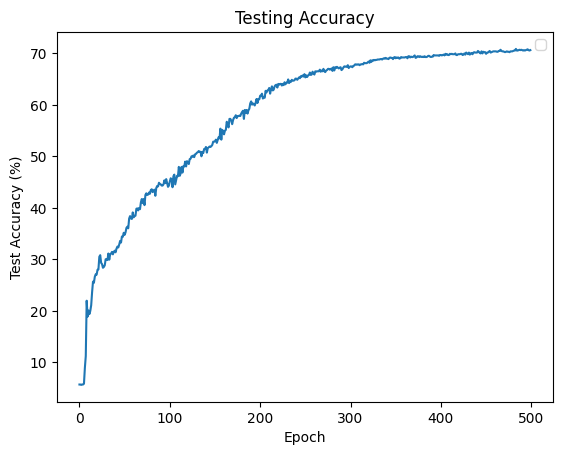

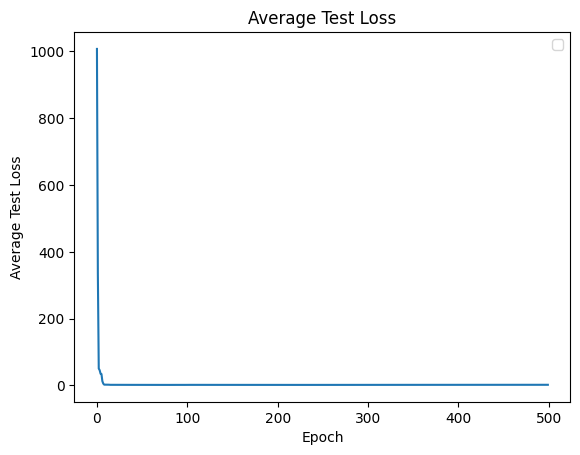

In [ ]:
plt.figure()
plt.plot(range(0, epochs), test_accuracy)
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(0, epochs), test_loss)
plt.title('Average Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Test Loss')
plt.legend()
plt.show()